# Predicting 4th Semester Performance (CP)

## First three modules' performances to predict fourth semester success

In [1]:
import pandas as pd
import numpy as np

from rapp import data

In [2]:
data.connect("data/rapp.db")

sql = "sql/cs_first_three_module_fourth_term_cp.sql"
df = data.query_sql_file(sql, data.db_conn)

In [3]:
df.head()

,Geburtsjahr,Geschlecht,Deutsch,LABestanden,LAVersuche,ProgBestanden,ProgVersuche,ProgNote,AlgoBestanden,AlgoVersuche,AlgoNote,AnaBestanden,AnaVersuche,FourthTermCP
0,1972,männlich,1,1,1,0,0,5.0,0,0,5.0,0,0,120.0
1,1987,weiblich,1,1,1,1,1,3.7,1,1,3.0,1,1,180.0
2,1985,männlich,1,0,0,1,1,1.7,0,0,5.0,0,0,70.0
3,1988,männlich,1,1,2,1,1,3.3,0,0,5.0,0,0,70.0
4,1989,weiblich,1,1,1,0,0,5.0,1,1,1.0,1,1,180.0


Let us change the task to a binary classification problem. Assuming 30 ECTP per term, we end up with 120 CP after the fourth semester. Giving some leeway, we allow for 20 CP to be missing (two modules).

In [4]:
df_classification = df.copy(deep=True)
df_classification["FourthTermCP"] = 1*(df_classification["FourthTermCP"] >= 100)

In [5]:
df_classification.head()

,Geburtsjahr,Geschlecht,Deutsch,LABestanden,LAVersuche,ProgBestanden,ProgVersuche,ProgNote,AlgoBestanden,AlgoVersuche,AlgoNote,AnaBestanden,AnaVersuche,FourthTermCP
0,1972,männlich,1,1,1,0,0,5.0,0,0,5.0,0,0,1
1,1987,weiblich,1,1,1,1,1,3.7,1,1,3.0,1,1,1
2,1985,männlich,1,0,0,1,1,1.7,0,0,5.0,0,0,0
3,1988,männlich,1,1,2,1,1,3.3,0,0,5.0,0,0,0
4,1989,weiblich,1,1,1,0,0,5.0,1,1,1.0,1,1,1


We need to one-hot encode the gender.

In [6]:
df_classification["Männlich"] = 1*(df_classification["Geschlecht"] == "männlich")
df_classification["Weiblich"] = 1*(df_classification["Geschlecht"] == "weiblich")
df_classification["Divers"] = 1*(df_classification["Geschlecht"] == "divers")

df_classification = df_classification.drop(["Geschlecht", "Geburtsjahr"], axis=1)

In [7]:
df_classification.head()

,Deutsch,LABestanden,LAVersuche,ProgBestanden,ProgVersuche,ProgNote,AlgoBestanden,AlgoVersuche,AlgoNote,AnaBestanden,AnaVersuche,FourthTermCP,Männlich,Weiblich,Divers
0,1,1,1,0,0,5.0,0,0,5.0,0,0,1,1,0,0
1,1,1,1,1,1,3.7,1,1,3.0,1,1,1,0,1,0
2,1,0,0,1,1,1.7,0,0,5.0,0,0,0,1,0,0
3,1,1,2,1,1,3.3,0,0,5.0,0,0,0,1,0,0
4,1,1,1,0,0,5.0,1,1,1.0,1,1,1,0,1,0


### Prepare train and test set

In [8]:
X = df_classification.drop(["FourthTermCP"], axis=1)
y = df_classification["FourthTermCP"]

feature_names = X.columns

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

### Train classifier

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [11]:
clf = DecisionTreeClassifier(class_weight="balanced", min_impurity_decrease=0.001)

In [12]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', min_impurity_decrease=0.001)

In [13]:
def eval_model(clf):
    y_pred = clf.predict(X_train)
    bacc = balanced_accuracy_score(y_train, y_pred)
    area = roc_auc_score(y_train, y_pred)
    conf = confusion_matrix(y_train, y_pred)
    print("# Trainset")
    print(f"Balanced accuracy: {bacc}")
    print(f"Area under curve: {area}")
    print(f"Confusion Matrix (tn, fp, fn, tp):")
    print(conf)

    y_pred = clf.predict(X_test)
    bacc = balanced_accuracy_score(y_test, y_pred)
    area = roc_auc_score(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)
    print("# Testset")
    print(f"Balanced accuracy: {bacc}")
    print(f"Area under curve: {area}")
    print(f"Confusion Matrix (tn, fp, fn, tp):")
    print(conf)

In [14]:
eval_model(clf)

# Trainset
Balanced accuracy: 0.8359115465247541
Area under curve: 0.8359115465247541
Confusion Matrix (tn, fp, fn, tp):
[[703 233]
 [ 21 244]]
# Testset
Balanced accuracy: 0.7754817275747508
Area under curve: 0.7754817275747508
Confusion Matrix (tn, fp, fn, tp):
[[214  87]
 [ 16  84]]


### Display rules learned

In [15]:
%matplotlib inline
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [60, 20]

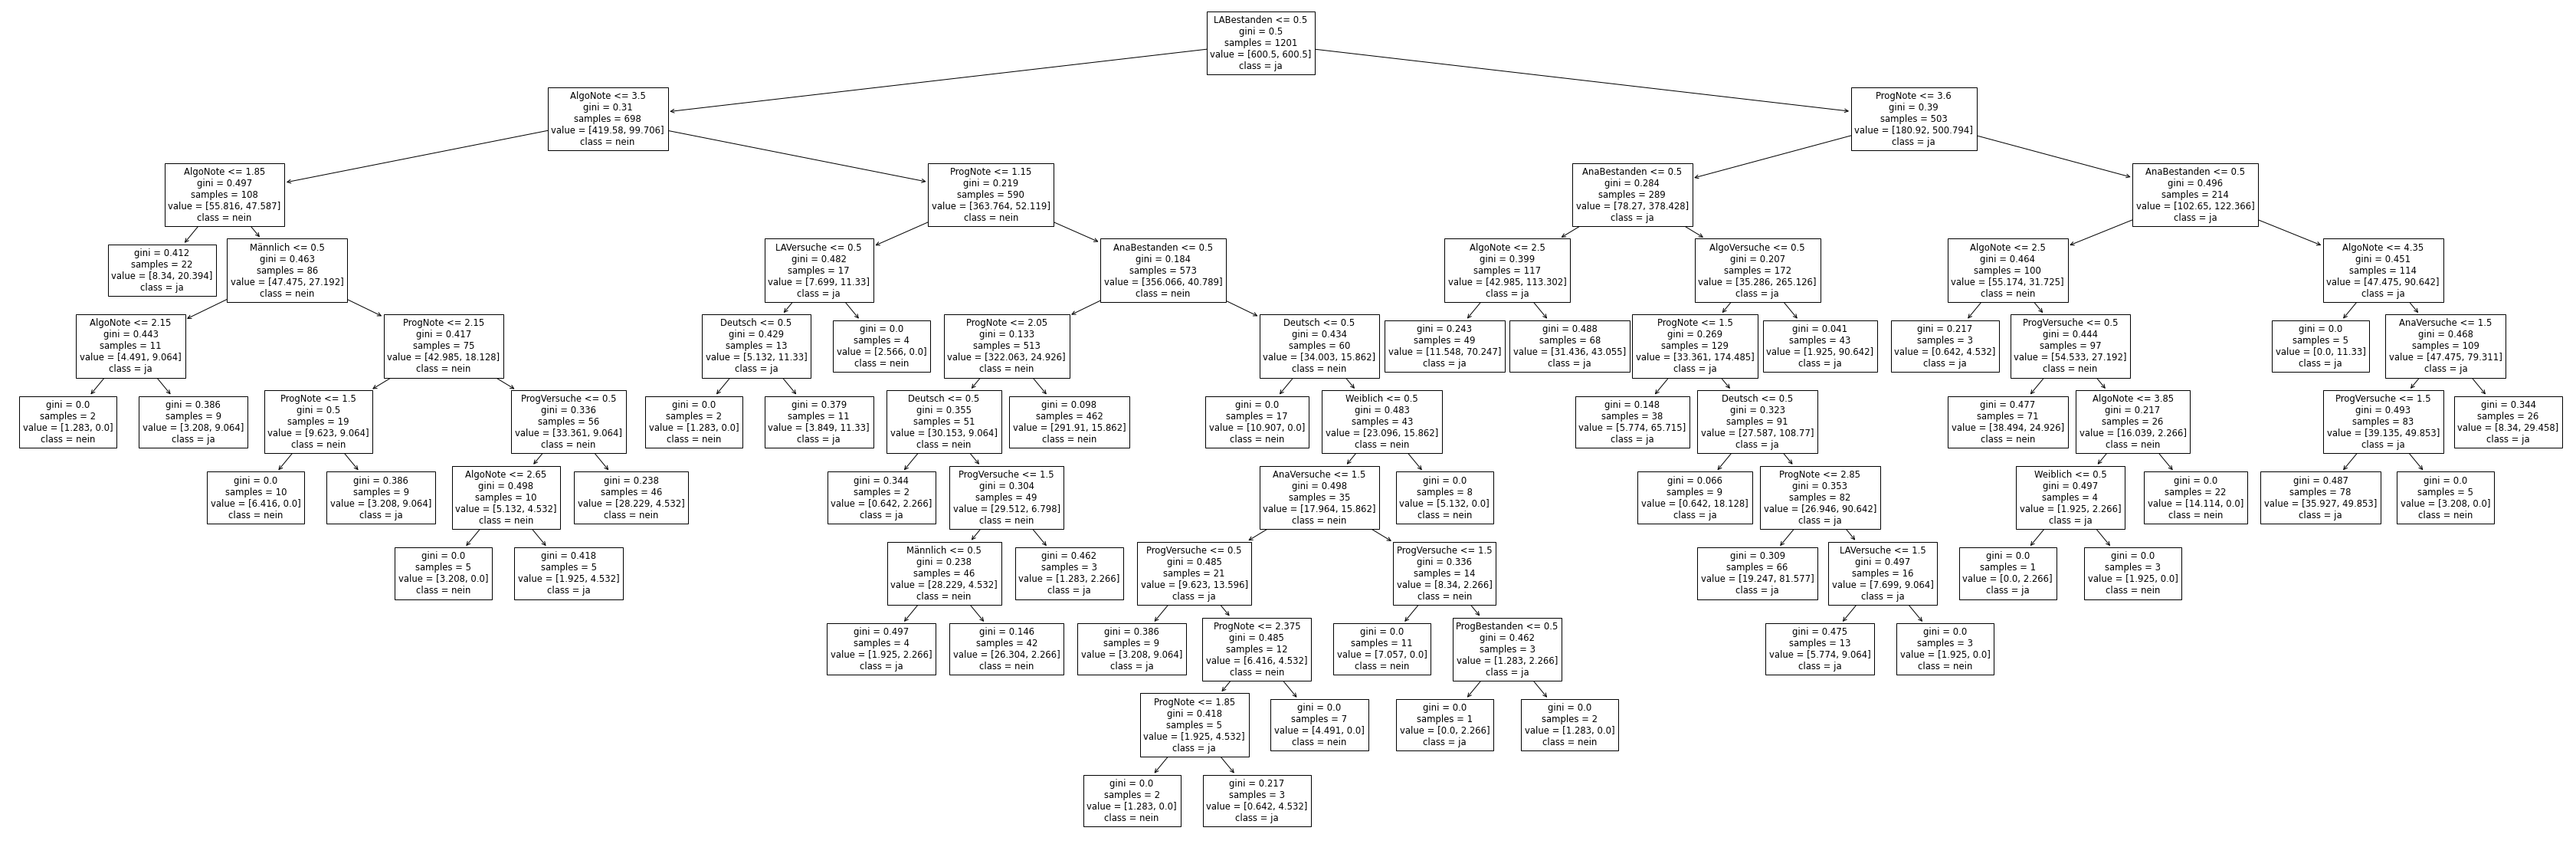

In [16]:
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

(Right click image -> open in new tab to get a zoomable version.)

Most discriminatory feature is LA1. Students who do not pass it will not have enough credits at end of fourth term.
Makes sense as students who do not pass it might not reach end of third term anyway.

## Explainable model: reduce complexity

In [17]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([0.        , 0.00105534, 0.00105869, 0.00109766, 0.00129572,
        0.00130083, 0.00131383, 0.00133387, 0.00155831, 0.00157179,
        0.00159426, 0.0016031 , 0.00165322, 0.0016544 , 0.00171483,
        0.00173922, 0.00175123, 0.00186821, 0.00208189, 0.00212143,
        0.00235238, 0.00239136, 0.00242852, 0.00265868, 0.00412635,
        0.00440336, 0.00468565, 0.00733871, 0.00753168, 0.01546619,
        0.0203622 , 0.14451748]),
 'impurities': array([0.23330475, 0.23436009, 0.23541878, 0.23651645, 0.23781217,
        0.24171467, 0.24302849, 0.24436236, 0.24747897, 0.24905076,
        0.25223929, 0.25384239, 0.25714883, 0.26045763, 0.26217246,
        0.26391168, 0.26566292, 0.26753113, 0.26961302, 0.27173445,
        0.27408683, 0.27647819, 0.27890671, 0.28688273, 0.29100908,
        0.29541244, 0.30478374, 0.31212245, 0.31965413, 0.33512032,
        0.35548252, 0.5       ])}

Text(0, 0.5, 'Balanced Accuracy scores')

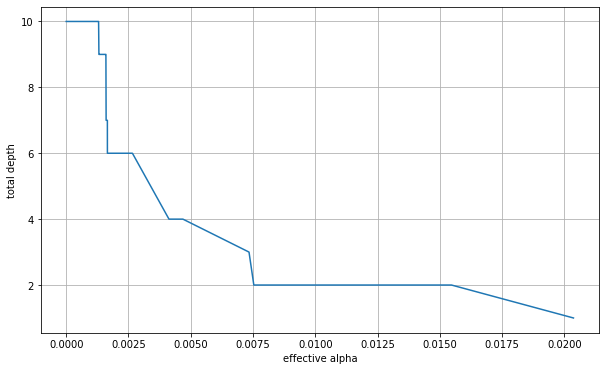

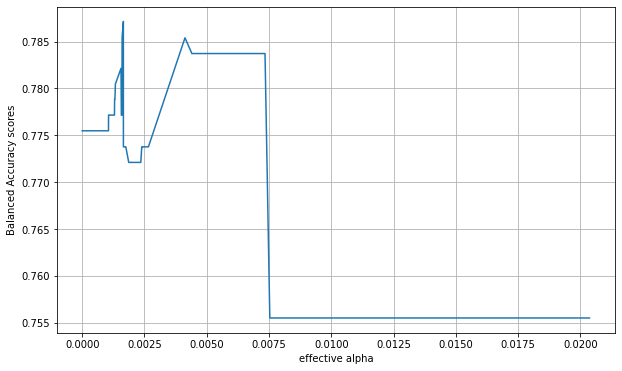

In [18]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,
                                 class_weight="balanced", min_impurity_decrease=0.001)
    clf.fit(X_train, y_train)
    clfs.append(clf)

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")


acc_scores = [balanced_accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Balanced Accuracy scores")


# Trainset
Balanced accuracy: 0.7858651830349943
Area under curve: 0.7858651830349943
Confusion Matrix (tn, fp, fn, tp):
[[740 196]
 [ 58 207]]
# Testset
Balanced accuracy: 0.7936877076411961
Area under curve: 0.793687707641196
Confusion Matrix (tn, fp, fn, tp):
[[237  64]
 [ 20  80]]


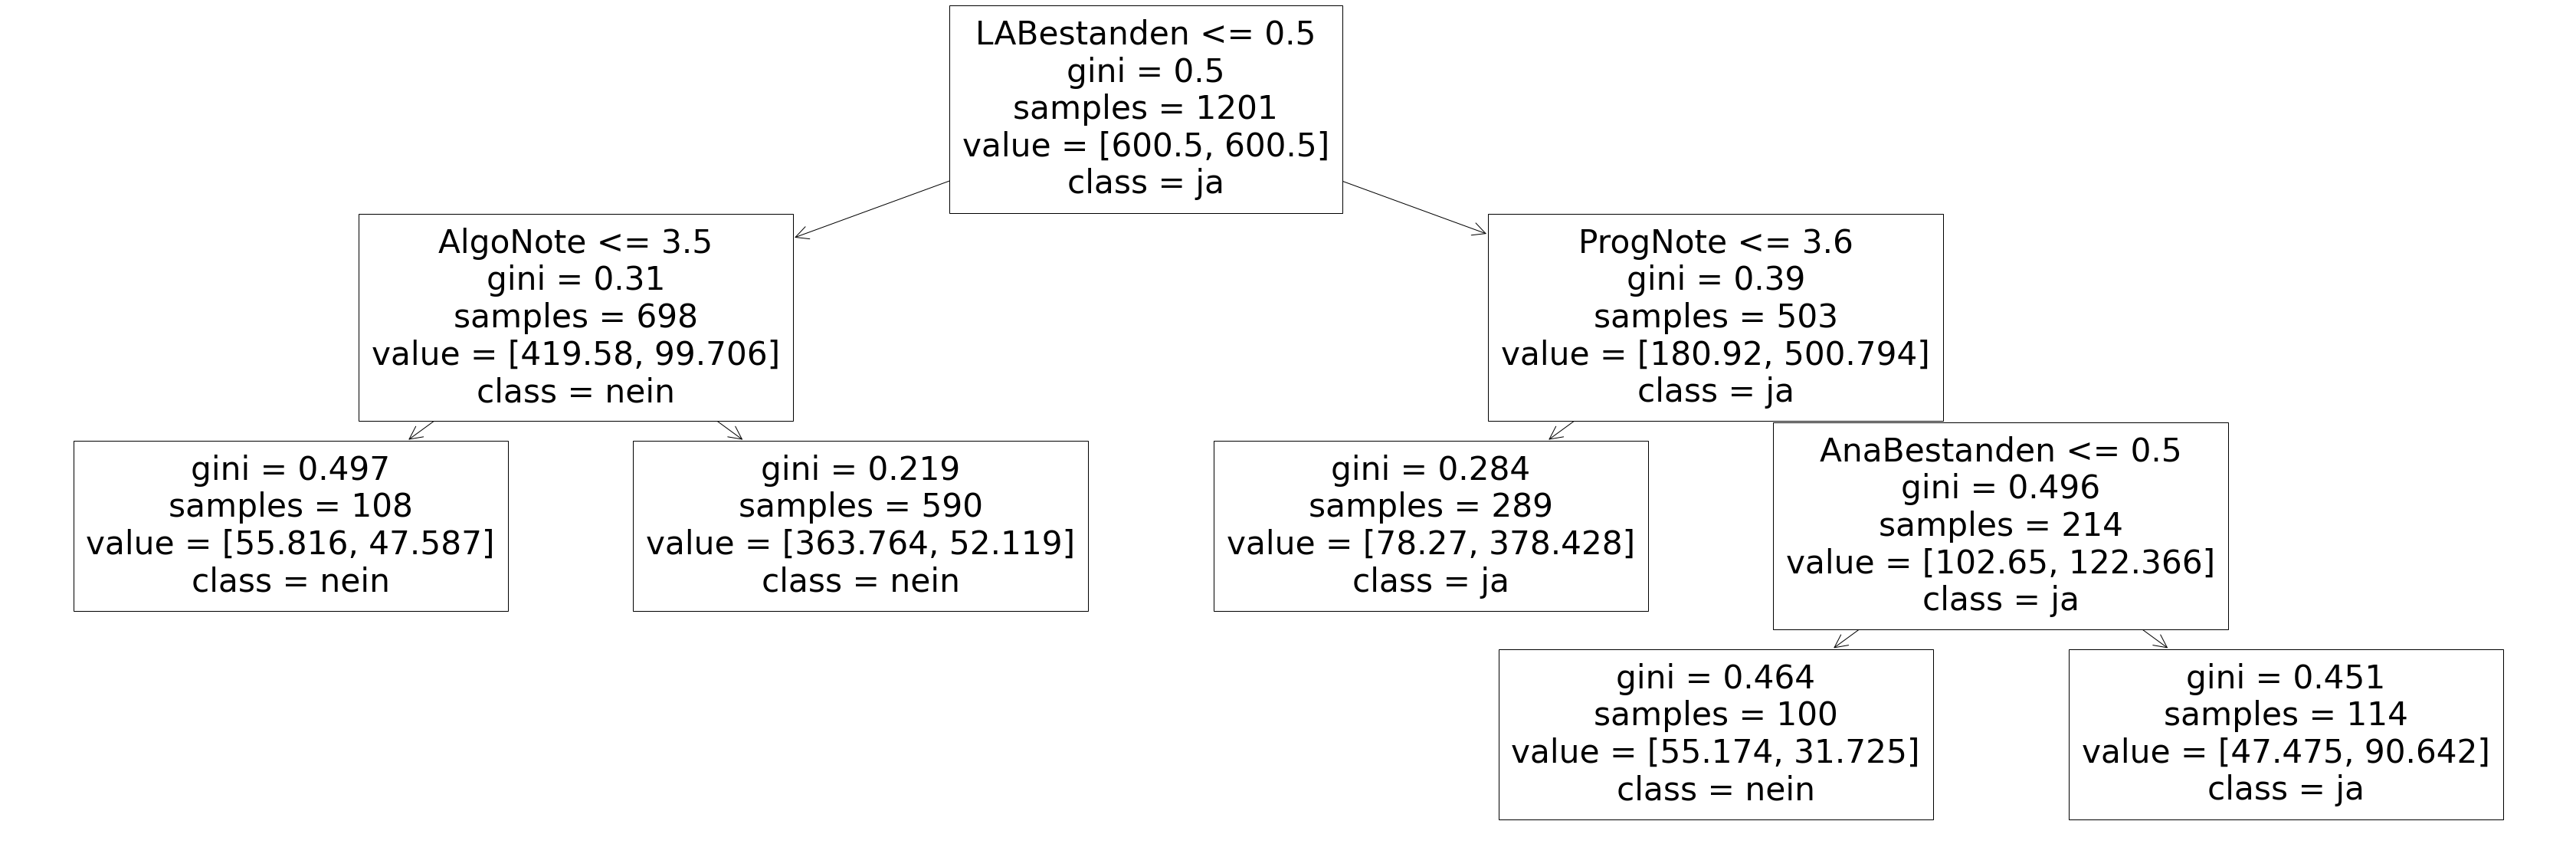

In [19]:
selected_ccp = 0.0075
# selected_ccp = 0.00733871

clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                             ccp_alpha=selected_ccp)
clf.fit(X_train, y_train)

eval_model(clf)
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()


## Assess Fairness of Classifier

In [20]:
from rapp.fairness import clf_group_fairness
from rapp.fairness import clf_predictive_parity

In [21]:
fairness = clf_group_fairness(clf, X_test, ["Männlich", "Deutsch"])

print("Statistical Parity, Sex:", fairness["Männlich"]["disparity"])
print("Statistical Parity, Race:", fairness["Deutsch"]["disparity"])

test = pd.concat([X_test, y_test], axis=1)
fairness = clf_predictive_parity(clf, test, "FourthTermCP", ["Männlich", "Deutsch"])

print("Predictive Parity, Sex:", fairness["Männlich"]["disparity"])
print("Predictive Parity, Race:", fairness["Deutsch"]["disparity"])


Statistical Parity, Sex: 0.007419183889772085
Statistical Parity, Race: 0.06454451345755696
Predictive Parity, Sex: -0.05198180636777128
Predictive Parity, Race: 0.12378426171529622


/data/RAPP/code/predictor/rapp/fairness.py:106: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  priv = df[df[ground_truth]==1][priv_mask]
/data/RAPP/code/predictor/rapp/fairness.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unpriv = df[df[ground_truth]==1][~priv_mask]
